In [4]:
#import library
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import gradio as gr
import warnings
warnings.filterwarnings("ignore")

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
stress = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv") 

# Transform Stress_level to categorical variable
def stress_cat(stress):
    conditions = [
        (stress['Stress Level'] >= 0) & (stress['Stress Level'] <= 3),
        (stress['Stress Level'] > 3) & (stress['Stress Level'] <= 6),
        (stress['Stress Level'] > 6) & (stress['Stress Level'] <= 10)
    ]
    choices = ['Low', 'Medium', 'High']
    stress['Stress Level'] = np.select(conditions, choices)
    return stress
stress = stress_cat(stress)

stress.head()

TypeError: Choicelist and default value do not have a common dtype: The DType <class 'numpy.dtypes._PyLongDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyLongDType'>)

In [3]:
# Display the data types, non-null counts, and memory usage.
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    object 
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 38.1+ KB


In [4]:
stress.shape

(374, 13)

In [5]:
# Checking the null values
stress.isnull().sum()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

In [6]:
# Handle missing values
stress['Sleep Disorder'].fillna('Nothing', inplace=True)
stress.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,Medium,Overweight,126/83,77,4200,Nothing
1,2,Male,28,Doctor,6.2,6,60,High,Normal,125/80,75,10000,Nothing
2,3,Male,28,Doctor,6.2,6,60,High,Normal,125/80,75,10000,Nothing
3,4,Male,28,Sales Representative,5.9,4,30,High,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,High,Obese,140/90,85,3000,Sleep Apnea


In [7]:
stress["BMI Category"].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

In [8]:
stress['BMI Category'] = stress['BMI Category'].replace({'Normal Weight': 'Normal'})

In [9]:
duplicate_rows = stress[stress.duplicated()]

print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [Person ID, Gender, Age, Occupation, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, BMI Category, Blood Pressure, Heart Rate, Daily Steps, Sleep Disorder]
Index: []


In [10]:
stress.nunique().to_frame('unique count').T

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
unique count,374,2,31,11,27,6,16,3,3,25,19,20,3


In [11]:
stress['Occupation'].unique()

array(['Software Engineer', 'Doctor', 'Sales Representative', 'Teacher',
       'Nurse', 'Engineer', 'Accountant', 'Scientist', 'Lawyer',
       'Salesperson', 'Manager'], dtype=object)

In [12]:
stress['Sleep Disorder'].unique()

array(['Nothing', 'Sleep Apnea', 'Insomnia'], dtype=object)

In [13]:
stress['BMI Category'].unique()

array(['Overweight', 'Normal', 'Obese'], dtype=object)

In [14]:
# Feature Engineering
stress[['Systolic BP', 'Diastolic BP']] = stress['Blood Pressure'].str.split('/', expand=True).astype(int)
stress['BP_Ratio'] = stress['Diastolic BP'] / stress['Systolic BP']
stress['Age_Group'] = pd.cut(stress['Age'], bins=[18,30,45,60,100], labels=['Young','Adult','Mid-Age','Senior'])

In [15]:
stress.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Systolic BP,Diastolic BP,BP_Ratio,Age_Group
0,1,Male,27,Software Engineer,6.1,6,42,Medium,Overweight,126/83,77,4200,Nothing,126,83,0.658730,Young
1,2,Male,28,Doctor,6.2,6,60,High,Normal,125/80,75,10000,Nothing,125,80,0.640000,Young
2,3,Male,28,Doctor,6.2,6,60,High,Normal,125/80,75,10000,Nothing,125,80,0.640000,Young
3,4,Male,28,Sales Representative,5.9,4,30,High,Obese,140/90,85,3000,Sleep Apnea,140,90,0.642857,Young
4,5,Male,28,Sales Representative,5.9,4,30,High,Obese,140/90,85,3000,Sleep Apnea,140,90,0.642857,Young


In [17]:
stress['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [19]:
# Drop unnecessary columns
stress.drop(['Person ID', 'Blood Pressure', 'Physical Activity Level'], axis=1, inplace=True)

In [20]:
# 1. Initial Data Prep (no transforms)
X = stress.drop('Stress Level', axis=1)
y = stress['Stress Level']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)



In [21]:
# 3. Define Feature Types
numeric_features = ['Age', 'Sleep Duration','Quality of Sleep','Heart Rate',
                    'Daily Steps','Systolic BP', 'Diastolic BP', 'BP_Ratio']

ordinal_features = ['BMI Category', 'Age_Group'] 
nominal_features = ['Gender','Occupation']

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(categories=[
            ['Overweight', 'Normal', 'Obese'],  # BMI Category
            ['Young','Adult','Mid-Age','Senior']   # Age_Group
        ]), ordinal_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ],
    remainder='drop'  
)


In [23]:
# 5. Process Data
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)  

In [24]:
X_train_process=pd.DataFrame(X_train_proc)
X_train_process

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.783916,0.067411,0.573130,-0.536879,0.115543,-1.746217,-1.577965,-0.472390,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.240122,-0.946720,-1.090615,0.421490,-0.506930,0.200051,0.067124,-0.340276,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.556352,0.828009,0.573130,-0.536879,0.115543,-1.097461,-0.755421,0.672591,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.101224,0.701242,0.573130,-0.057694,0.738015,0.200051,0.067124,-0.340276,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.556352,0.067411,0.573130,-0.536879,0.115543,-1.746217,-1.577965,-0.472390,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.240122,-0.693187,-0.258743,-1.255655,-0.506930,0.848807,0.889669,0.672591,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295,0.922813,-1.327019,-1.090615,1.140266,1.982961,1.497563,1.712213,1.613110,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
296,-0.556352,0.067411,0.573130,-0.536879,0.115543,-1.746217,-1.577965,-0.472390,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.922813,-1.327019,-1.090615,1.140266,1.982961,1.497563,1.712213,1.613110,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Handle Class Imbalance (ONLY on training)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

In [26]:
unique_values, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique_values, counts)))

{'High': 146, 'Low': 146, 'Medium': 146}


In [27]:
#  Hyperparameter Tuning
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

In [28]:
# Model Training and Evaluation
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42,  
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [29]:
# Set up cross-validation with fixed randomness
cv = StratifiedKFold(
    n_splits=5,       # 5-fold cross-validation
    shuffle=True,     # Shuffle the data before splitting
    random_state=42   # Fixes the randomness in data splitting
)

In [30]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=cv,            
    scoring='accuracy',
    n_jobs=-1,        
    verbose=1         
)


In [31]:
# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train_res, y_train_res)

Starting Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                              min_samples_split=5,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [32]:
# Get best model
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Validation Accuracy: {grid_search.best_score_:.2f}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Validation Accuracy: 0.99


In [33]:
# Evaluate on test set
y_pred = best_rf.predict(X_test_proc)

# Model Evaluation Metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        24
         Low       1.00      1.00      1.00        14
      Medium       1.00      1.00      1.00        37

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



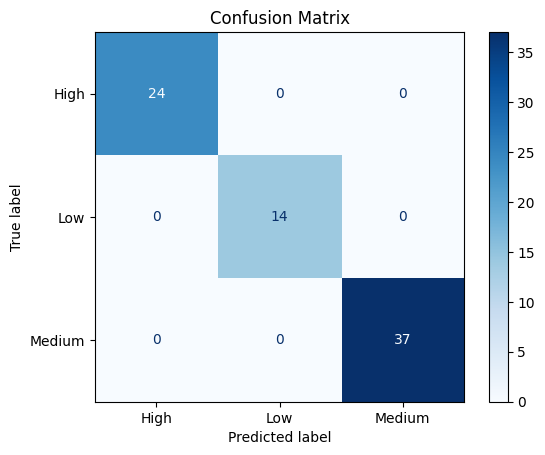

In [34]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=best_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Feature Importance Analysis
# Get feature names after preprocessing
numeric_feature_names = numeric_features
ordinal_feature_names = ordinal_features

In [36]:
# Get OneHot encoded feature names
ohe = preprocessor.named_transformers_['nom']
nominal_feature_names = ohe.get_feature_names_out(nominal_features)
all_feature_names = numeric_feature_names + ordinal_feature_names + list(nominal_feature_names)

In [37]:
print(all_feature_names)

['Age', 'Sleep Duration', 'Quality of Sleep', 'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP', 'BP_Ratio', 'BMI Category', 'Age_Group', 'Gender_Female', 'Gender_Male', 'Occupation_Accountant', 'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Lawyer', 'Occupation_Nurse', 'Occupation_Sales Representative', 'Occupation_Salesperson', 'Occupation_Scientist', 'Occupation_Software Engineer', 'Occupation_Teacher']


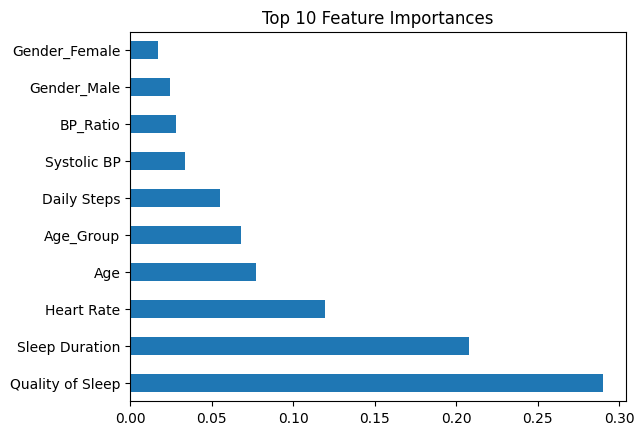

In [38]:
# Plot feature importances
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=all_feature_names)
feat_importances.nlargest(10).plot(kind='barh', title='Top 10 Feature Importances')
plt.show()

In [39]:
#  Model Saving
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(best_rf, 'stress_predictor.pkl')

['stress_predictor.pkl']

In [40]:
# Prediction Function
def predict_stress_level():
    try:
        # Load saved components
        preprocessor = joblib.load('preprocessor.pkl')
        model = joblib.load('stress_predictor.pkl')
        
        print("Enter the following details:")
        inputs = {
            'Gender': input("Gender (Male/Female): "),
            'Age': int(input("Age: ")),
            'Occupation': input("Occupation: "),
            'Sleep Duration': float(input("Sleep Duration (hours): ")),
            'Quality of Sleep': int(input("Sleep Quality (1-10): ")),
            'BMI Category': input("BMI Category (Underweight/Normal/Overweight/Obese): "),
            'Heart Rate': int(input("Heart Rate (bpm): ")),
            'Daily Steps': int(input("Daily Steps: ")),
            'Systolic BP': int(input("Systolic BP: ")),
            'Diastolic BP': int(input("Diastolic BP: "))
        }
        
        # Create DataFrame
        input_df = pd.DataFrame([inputs])
        
        # Calculate derived features
        input_df['BP_Ratio'] = input_df['Diastolic BP'] / input_df['Systolic BP']
        input_df['Age_Group'] = pd.cut(input_df['Age'], 
                                     bins=[18,30,45,60,100],
                                     labels=['Young','Adult','Mid-Age','Senior'])
        
        # Preprocess and predict
        processed_input = preprocessor.transform(input_df)
        prediction = model.predict(processed_input)
        
        print(f"\nPredicted Stress Level: {prediction[0]}")
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("Please check your input values and try again.")


In [41]:
# pip install gradio

In [42]:
# # Load model
# preprocessor = joblib.load('preprocessor.pkl')
# model = joblib.load('stress_predictor.pkl')

# def predict(gender, age, occupation, sleep_duration, sleep_quality, 
#             bmi_category, heart_rate, daily_steps, systolic_bp, diastolic_bp):
#     input_data = {
#         'Gender': gender.capitalize(),
#         'Age': age,
#         'Occupation': occupation,
#         'Sleep Duration': sleep_duration,
#         'Quality of Sleep': sleep_quality,
#         'BMI Category': bmi_category.capitalize(),
#         'Heart Rate': heart_rate,
#         'Daily Steps': daily_steps,
#         'Systolic BP': systolic_bp,
#         'Diastolic BP': diastolic_bp
#     }
    
#     input_df = pd.DataFrame([input_data])
#     input_df['BP_Ratio'] = input_df['Diastolic BP'] / input_df['Systolic BP']
#     input_df['Age_Group'] = pd.cut(input_df['Age'], 
#                                  bins=[18,30,45,60,100],
#                                  labels=['Young','Adult','Mid-Age','Senior'])
    
#     processed_input = preprocessor.transform(input_df)
#     prediction = model.predict(processed_input)
    
#     return int(prediction[0])

# iface = gr.Interface(
#     fn=predict,
#     inputs=[
#         gr.Dropdown(["Male", "Female"], label="Gender"),
#         gr.Number(label="Age"),
#         gr.Textbox(label="Occupation"),
#         gr.Number(label="Sleep Duration (hours)"),
#         gr.Slider(1, 10, step=1, label="Sleep Quality (1-10)"),
#         gr.Dropdown(["Normal", "Overweight", "Obese"], label="BMI Category"),
#         gr.Number(label="Heart Rate (bpm)"),
#         gr.Number(label="Daily Steps"),
#         gr.Number(label="Systolic BP"),
#         gr.Number(label="Diastolic BP")
#     ],
#     outputs="number",
#     title="Stress Level Predictor",
#     description="Enter your health metrics to predict your stress level (0-10)"
# )

# iface.launch()